In [288]:
import numpy as np
import matplotlib.pyplot as plt

# Planning a Fast Rescue Boat Mission with an Extended Kalman Filter

1. Generate the boat's true trajectory under random accelerations.
2. Simulate noisy range and bearing (azimuth) measurements from the radar.
3. Implement an EKF to fuse predictions and measurements.
4. Analyze when and why the filter works, and where it struggles.

## 1. Trajectory estimation

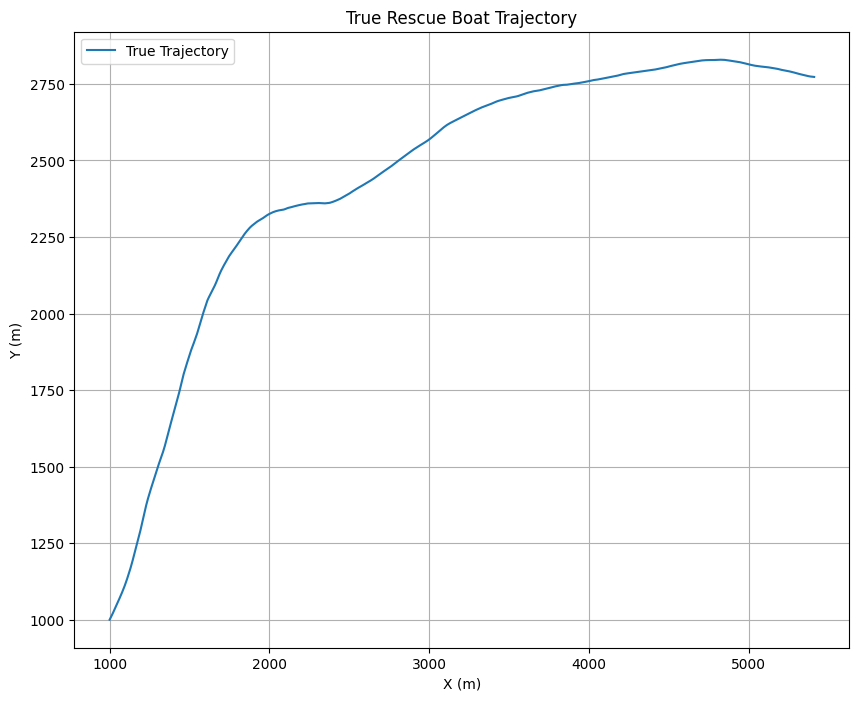

In [299]:
N = 500
T = 1
x0 = 1000
y0 = 1000
vx0 = 10
vy0 = 10
sigma_a = 0.3

def generate_trajectory(x0=x0, y0=y0, vx0=vx0, vy0=vy0, T=T, N=N):
    X_true = np.zeros((N, 4, 1))
    X_true[0] = np.array([[x0], [vx0], [y0], [vy0]])

    for i in range(1, N):
        xi_prev, vxi_prev, yi_prev, vyi_prev = X_true[i-1]
        ax = np.random.normal(0, sigma_a, N)
        ay = np.random.normal(0, sigma_a, N)
        axi_prev, ayi_prev = ax[i-1], ay[i-1]

        xi = xi_prev + vxi_prev * T + 0.5 * axi_prev * T**2
        vxi = vxi_prev + axi_prev * T
        yi = yi_prev + vyi_prev * T + 0.5 * ayi_prev * T**2
        vyi = vyi_prev + ayi_prev * T
        
        X_true[i] = np.array([[xi[0]], [vxi[0]], [yi[0]], [vyi[0]]])

    return X_true

X_true = generate_trajectory()

x_true = X_true[:, 0, 0]
y_true = X_true[:, 2, 0]

def to_polar(x, y):
    D = np.sqrt(x**2 + y**2)
    beta = np.arctan2(x, y)
    return D, beta

D_true, beta_true = to_polar(x_true, y_true)

plt.figure(figsize=(10, 8))
plt.plot(x_true, y_true, label='True Trajectory')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('True Rescue Boat Trajectory')
plt.grid(True)
plt.legend()
plt.show()

## 2. Measurement generation

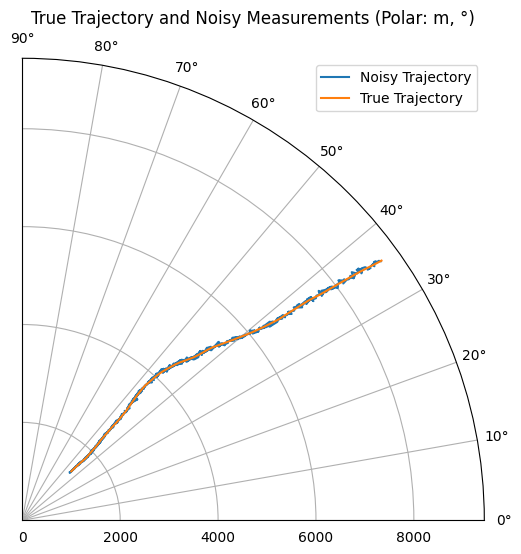

In [290]:
sigma_D = 50
sigma_beta = 0.004

def generate_measurements(D_true, beta_true, sigma_D=sigma_D, sigma_beta=sigma_beta, N=N):
    noise_D = np.random.normal(0, sigma_D, N)
    D_m = D_true + noise_D

    noise_beta = np.random.normal(0, sigma_beta, N)
    beta_m = beta_true + noise_beta
    return D_m, beta_m

Dm, betam = generate_measurements(D_true, beta_true)

z = np.hstack((Dm.reshape(-1, 1), betam.reshape(-1, 1)))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(polar=True)
ax.plot(betam, Dm, label='Noisy Trajectory')
ax.plot(beta_true, D_true, label='True Trajectory')
ax.set_title('True Trajectory and Noisy Measurements (Polar: m, °)')
ax.set_thetalim(np.deg2rad(0),np.deg2rad(90))
ax.legend()
plt.show()

## 3. Initial conditions for the Extended Kalman filter algorithm

In [291]:
def to_cartesian(D, beta):
    x = D * np.sin(beta)
    y = D * np.cos(beta)
    return x, y

D0m, beta0m = z[0]
x0_est, y0_est = to_cartesian(D0m, beta0m)

X0_0 = np.array([[x0_est], [0], [y0_est], [0]])

P0_0 = np.eye(4) * 10**10

## 4. Filter settings

In [292]:
Phi = np.array([[1, T, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, T],
                [0, 0, 0, 1]])
                
R = np.array([[sigma_D**2, 0],
              [0, sigma_beta**2]])

## 5. Kalman filter algorithm

Standart Kalman Filter has been adapted to an Extended Kalman Filter by calculating the Jacobian of the measurement function at each time step. The state noise covariance matrix `Q` is also calculated within the filter based on the process noise variance.

In [293]:
def calculate_R(D, beta, sigma_D, sigma_beta):
    return np.array([[sigma_D**2, 0],
                     [0, sigma_beta**2]])

In [294]:
def run_kalman_filter(z, N, Phi, X0_0, P0_0, sigma_a, sigma_D, sigma_beta):
    X_filt_prev = X0_0
    P_filt_prev = P0_0

    X_predicted = np.zeros((N, 4, 1))
    P_predicted = np.zeros((N, 4, 4))
    X_filtered = np.zeros((N, 4, 1))
    P_filtered = np.zeros((N, 4, 4))

    T = 1
    G = np.array([[T**2 / 2, 0], [T, 0], [0, T**2 / 2], [0, T]])
    Q = G @ G.T * sigma_a**2

    for i in range(N):
        X_pred = Phi @ X_filt_prev
        P_pred = Phi @ P_filt_prev @ Phi.T + Q

        x_p, y_p = X_pred[0, 0], X_pred[2, 0]
        
        D_p, betta_p = to_polar(x_p, y_p)

        #linearization
        H = np.array([[x_p / D_p, 0, y_p / D_p, 0],
                        [y_p / (D_p**2), 0, -x_p / (D_p**2), 0]])

        Ri = calculate_R(D_p, 0, sigma_D, sigma_beta) 
        K = P_pred @ H.T @ np.linalg.inv(H @ P_pred @ H.T + Ri)

        z_pred = np.array([[D_p], [betta_p]])
        
        residual = z[i].reshape(2,1) - z_pred

        residual[1, 0] = (residual[1, 0] + np.pi) % (2 * np.pi) - np.pi

        X_filt = X_pred + K @ residual
        P_filt = (np.eye(4) - K @ H) @ P_pred

        X_predicted[i], P_predicted[i] = X_pred, P_pred
        X_filtered[i], P_filtered[i] = X_filt, P_filt
            
        X_filt_prev, P_filt_prev = X_filt, P_filt
    
    return X_filtered, P_filtered, X_predicted, P_predicted

## 6. Error estimation

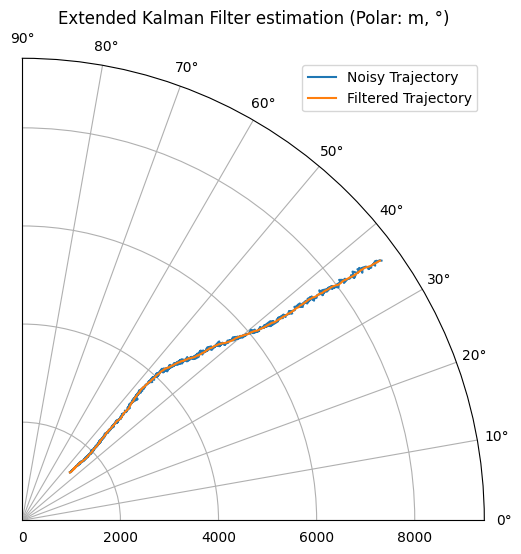

In [295]:
X_filtered, P_filtered, X_predicted, P_predicted = run_kalman_filter(
    z, N, Phi, X0_0, P0_0, sigma_a, sigma_D, sigma_beta
)

x_filt = X_filtered[:, 0, 0]
y_filt = X_filtered[:, 2, 0]

x_pred = X_predicted[:, 0, 0]
y_pred = X_predicted[:, 2, 0]

D_filt, beta_filt = to_polar(x_filt, y_filt)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(polar=True)
ax.plot(betam, Dm, label='Noisy Trajectory')
ax.plot(beta_filt, D_filt, label='Filtered Trajectory')
ax.set_title('Extended Kalman Filter estimation (Polar: m, °)')
ax.legend()
ax.set_thetalim(np.deg2rad(0),np.deg2rad(90))
plt.show()

In [296]:
def to_cartesian(D, beta):
    x = D * np.sin(beta)
    y = D * np.cos(beta)
    return x, y

In [297]:
def calculate_errors(M, D_true, beta_true, N, Phi, X0_0, P0_0, sigma_D, sigma_beta):
    err_D_pred_sq = np.zeros((M, N))
    err_D_filt_sq = np.zeros((M, N))
    err_beta_pred_sq = np.zeros((M, N))
    err_beta_filt_sq = np.zeros((M, N))

    for m in range(M):
        Dm, betam = generate_measurements(D_true, beta_true)
        z = np.hstack((Dm.reshape(-1, 1), betam.reshape(-1, 1)))

        X_f, _, X_p, _ = run_kalman_filter(z, N, Phi, X0_0, P0_0, sigma_a, sigma_D, sigma_beta)

        D_pred, beta_pred = to_polar(X_p[:, 0, 0], X_p[:, 2, 0])
        D_filt, beta_filt = to_polar(X_f[:, 0, 0], X_f[:, 2, 0])

        err_D_pred_sq[m, :] = (D_pred - D_true)**2
        err_D_filt_sq[m, :] = (D_filt - D_true)**2
        err_beta_pred_sq[m, :] = (beta_pred - beta_true)**2
        err_beta_filt_sq[m, :] = (beta_filt - beta_true)**2

    rmse_D_pred = np.sqrt(np.mean(err_D_pred_sq, axis=0))
    rmse_D_filt = np.sqrt(np.mean(err_D_filt_sq, axis=0))
    rmse_beta_pred = np.sqrt(np.mean(err_beta_pred_sq, axis=0))
    rmse_beta_filt = np.sqrt(np.mean(err_beta_filt_sq, axis=0))

    return rmse_D_pred, rmse_D_filt, rmse_beta_pred, rmse_beta_filt

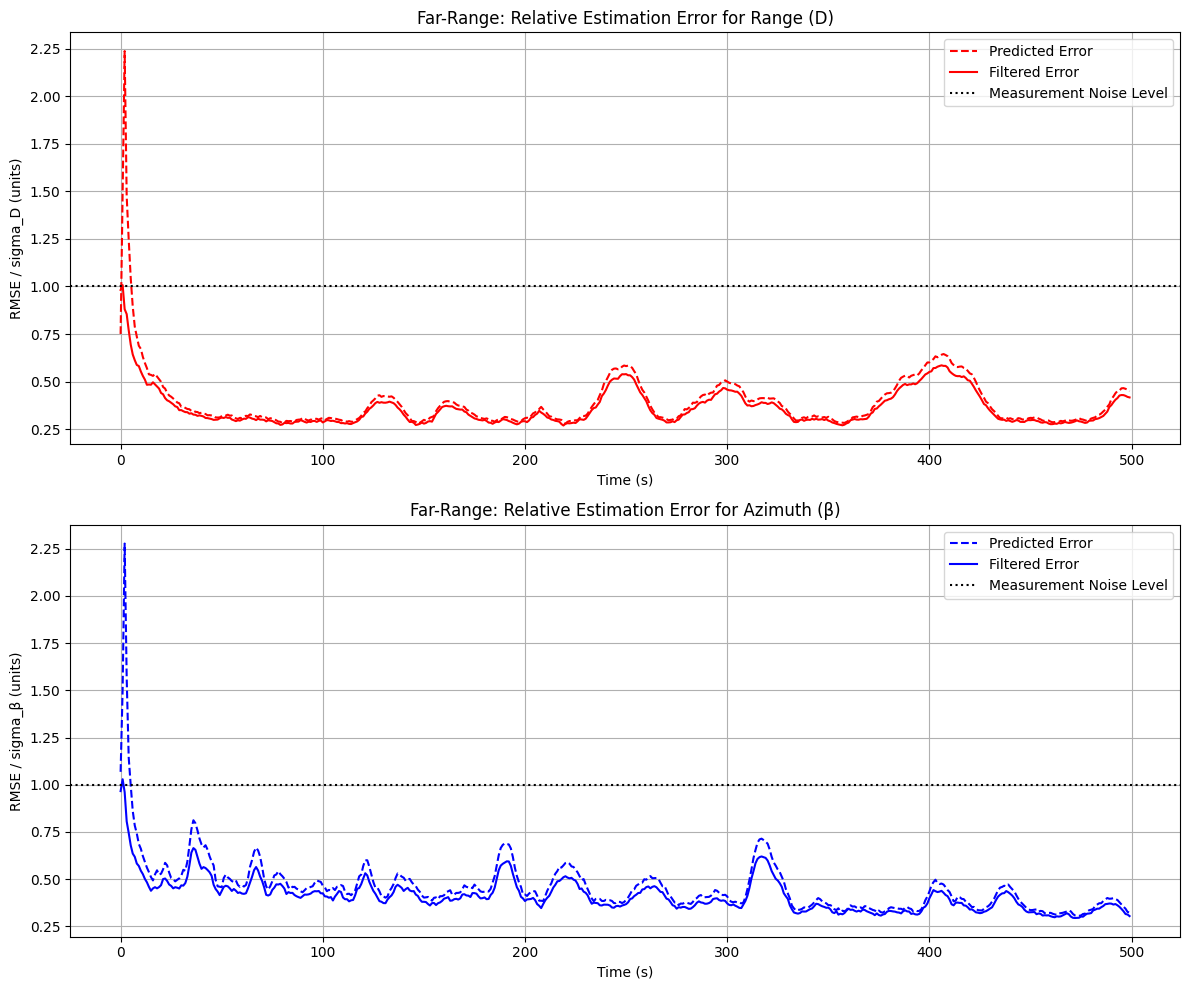

In [298]:
M = 500
rmse_D_p, rmse_D_f, rmse_b_p, rmse_b_f = calculate_errors(M, D_true, beta_true, N, Phi, X0_0, P0_0, sigma_D, sigma_beta)

time = np.arange(N) * T
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

ax1.plot(time, rmse_D_p / sigma_D, 'r--', label='Predicted Error')
ax1.plot(time, rmse_D_f / sigma_D, 'r-', label='Filtered Error')
ax1.set_title('Far-Range: Relative Estimation Error for Range (D)')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('RMSE / sigma_D (units)')
ax1.axhline(1.0, color='k', linestyle=':', label='Measurement Noise Level')
ax1.legend()
ax1.grid()

ax2.plot(time, rmse_b_p / sigma_beta, 'b--', label='Predicted Error')
ax2.plot(time, rmse_b_f / sigma_beta, 'b-', label='Filtered Error')
ax2.set_title('Far-Range: Relative Estimation Error for Azimuth (β)')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('RMSE / sigma_β (units)')
ax2.axhline(1.0, color='k', linestyle=':', label='Measurement Noise Level')
ax2.legend()

ax2.grid()

plt.tight_layout()
plt.show()

## Report

1. The measurement model, which converts Cartesian coordinates to polar coordinates, is nonlinear. The EKF handles this by linearizing the measurement function at each time step using a Jacobian matrix.
2. The EKF successfully filtered the noisy radar measurements to produce a smooth and accurate estimate of the trajectory. The filtered trajectory closely follows the true trajectory, significantly reducing the noise present in the raw measurements.
3. The error plots for both range and azimuth clearly show that the filtered estimates have significantly lower error compared to the raw measurements. The prediction errors are a little bit larger than the filtered errors, which is expected as the filtering step incorporates the measurement to correct the prediction.
4. The EKF's performance relies on the assumption that the linearization is a good approximation of the nonlinear function. In cases of high nonlinearity or large uncertainties, this assumption can break down, leading to filter divergence. In this specific problem, the nonlinearities were manageable, and the filter performed well.

The Extended Kalman Filter is a usefull tool for state estimation in nonlinear systems. By linearizing the system dynamics, it extends the principles of the linear Kalman filter to a wider range of applications.